In [ ]:
import dlib # 이미지 처리 라이브러리 (face detection, face alignment, landmark detection)
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

# Load Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
detector = dlib.get_frontal_face_detector() # face detector 모델을 불러옴
sp = dlib.shape_predictor('/content/drive/MyDrive/D&A_conference/BeautyGAN/models/shape_predictor_5_face_landmarks.dat') # 5개의 점을 사용한 랜드마크 모델 불러옴.

# Load Images

In [ ]:
# 아이사 이미지 불러오기
img = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/정하.jpg') # 이미지를 로드

plt.figure(figsize=(16, 10))
plt.imshow(img)

# Find Faces

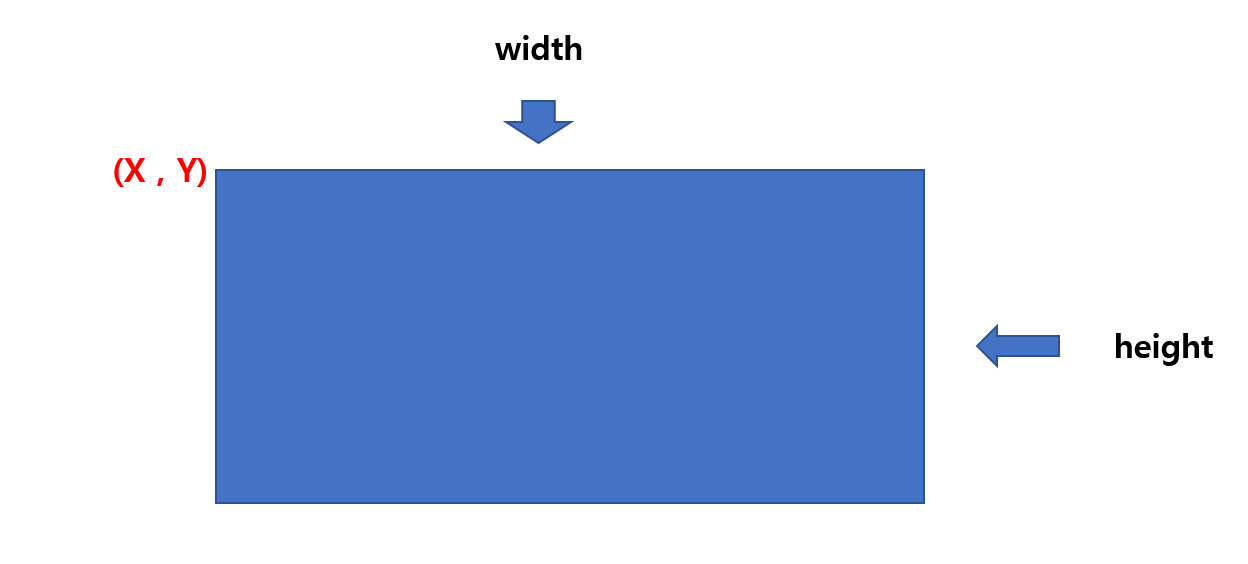

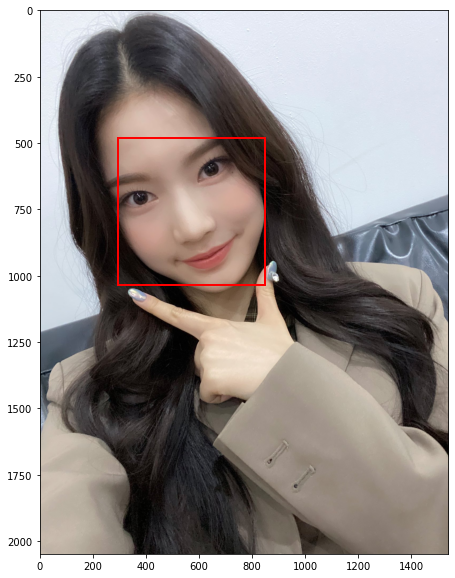

In [ ]:
img_result = img.copy()

dets = detector(img, 1) # detector에 img를 넣어줌

if len(dets) == 0: # 만약 얼굴 영역의 개수가 0이면(얼굴을 못 찾으면)
    print('cannot find faces!') # 얼굴 못찾았어!

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets: # det에는 정사각형 object가 들어있음
    x, y, w, h = det.left(), det.top(), det.width(), det.height() # 

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none') # 직사각형을 그리는 matplotlib의 patches.Rectangle
    ax.add_patch(rect)

ax.imshow(img_result)

# Find Landmarks 5points

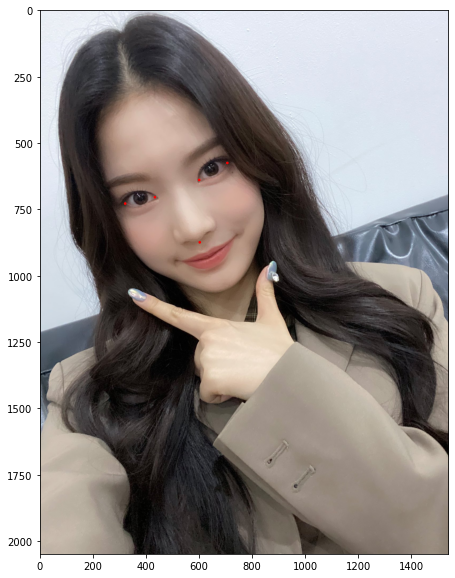

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections()

for detection in dets:
    s = sp(img, detection) # 모델에 (이미지, 얼굴의 위치)를 넣어주어 랜드마크를 찾음.
    objs.append(s)
    
    for point in s.parts(): # 5개의 점이 있으므로 for문이 5번 돌게 됨.
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)
# 5개의 랜드마크는 눈 양끝점 4개, 코 1개이다.

# Align Faces

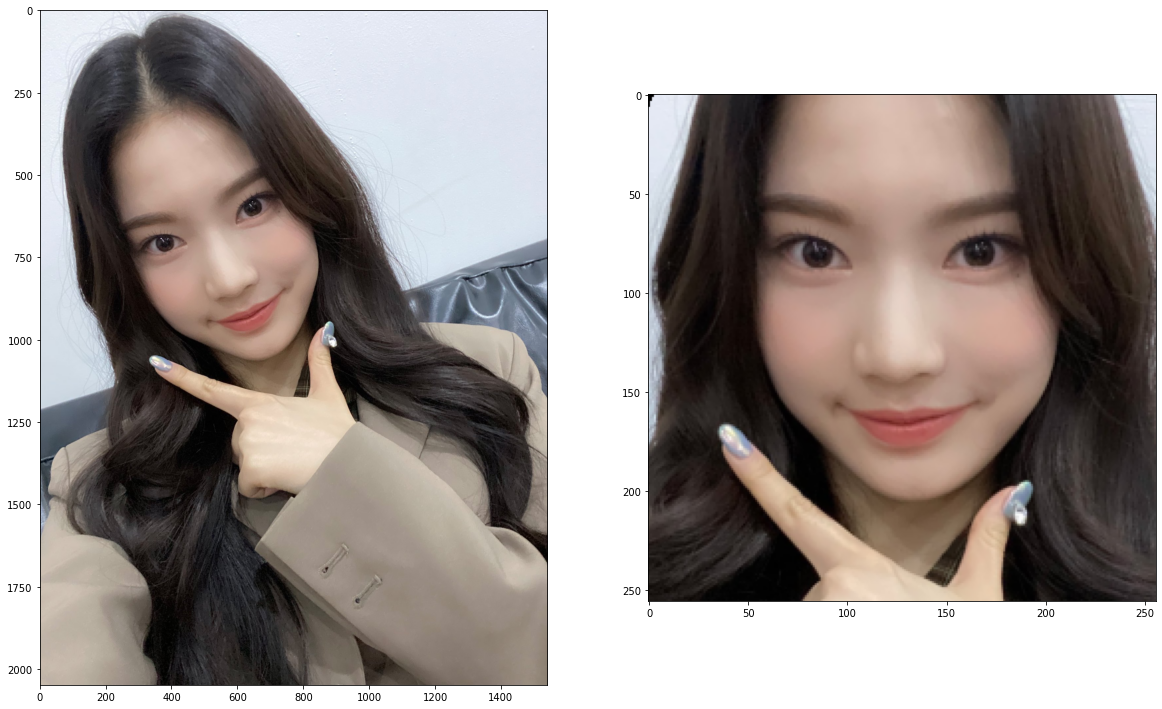

In [ ]:
# 얼굴의 수평을 맞추어 줄것임.
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3) # alignment하는 것으로 얼굴을 수평으로 회전하여 얼굴 부분만 자른 이미지를 반환 (원본 이미지, full object detection, 얼굴을 자르는 사이즈,padding 값)
# padding을 작게 할수록 더 타이트하게 짜름 

fig, axes = plt.subplots(1, len(faces)+1, figsize=(20, 16))

axes[0].imshow(img)

for i, face in enumerate(faces):
    axes[i+1].imshow(face)

In [ ]:
faces[0].flatten().shape
faces[0].flatten().reshape(-1,196608)

array([[ 14,  17,  24, ..., 148, 152, 162]], dtype=uint8)

# Functionalize

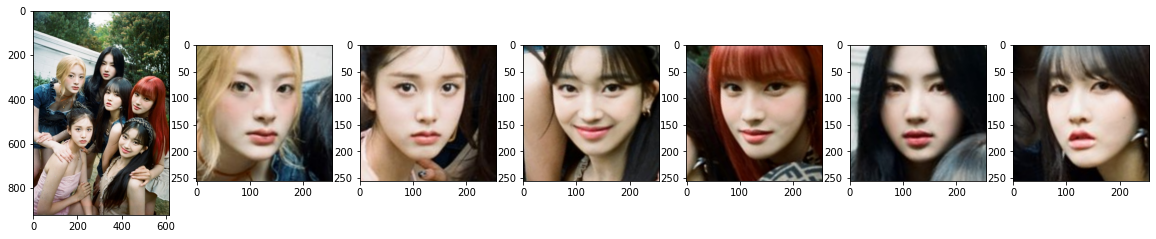

In [ ]:
# 이미지 test
def align_faces(img):
    dets = detector(img, 1) # object detection 먼저 하고
    
    objs = dlib.full_object_detections() 

    for detection in dets: # 랜드마크 찾고
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35) # face alignment 수행.
    
    return faces

# test
test_img = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/스테이씨.jpg')

test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20, 16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

# Load BeautyGAN Pretrained
- https://drive.google.com/drive/folders/1pgVqnF2-rnOxcUQ3SO4JwHUFTdiSe5t9

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
# tensorflow 버전이 2.x 대여서 session 오류가 발생하므로 아래 코드를 통해 오류 해결 1.x 버전으로 실행할 수 있게 해주는듯.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('/content/drive/MyDrive/D&A_conference/BeautyGAN/models/model.meta') # 모델의 그래프를 import 
saver.restore(sess, tf.train.latest_checkpoint('/content/drive/MyDrive/D&A_conference/BeautyGAN/models')) # 모델의 weight를 불러온다.
graph = tf.get_default_graph()

# 그래프에서 노드의 이름으로 tesnor를 불러옴
X = graph.get_tensor_by_name('X:0') # source
Y = graph.get_tensor_by_name('Y:0') # reference
Xs = graph.get_tensor_by_name('generator/xs:0') # output

# Preprocess and Postprocess Functions

In [ ]:
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

# Load Images

In [ ]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/우리_이미지/상우2.jpg') # 소스 이미지 (no-makeup)
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/봄웜톤.jpg') # 레퍼런스 이미지(reference image) 봄웜톤
img2_faces = align_faces(img2)

img3 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/정채연.png') # 레퍼런스 이미지(reference image) 여름쿨톤
img3_faces = align_faces(img3)

img4 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/제니.png') # 레퍼런스 이미지(reference image) 가을웜톤
img4_faces = align_faces(img4)

img5 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/카리나.jpg') # 레퍼런스 이미지(reference image) 겨울쿨톤
img5_faces = align_faces(img5)

fig, axes = plt.subplots(1, 5, figsize=(16, 10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])
axes[2].imshow(img3_faces[0])
axes[3].imshow(img4_faces[0])
axes[4].imshow(img5_faces[0])

# Run

In [ ]:
src_img = img1_faces[0]
ref1_img = img2_faces[0]
ref2_img = img3_faces[0]
ref3_img = img4_faces[0]
ref4_img = img5_faces[0]

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0) # 배열에 차원을 추가

Y1_img = preprocess(ref1_img)
Y1_img = np.expand_dims(Y1_img, axis=0)

Y2_img = preprocess(ref2_img)
Y2_img = np.expand_dims(Y2_img, axis=0)

Y3_img = preprocess(ref3_img)
Y3_img = np.expand_dims(Y3_img, axis=0)

Y4_img = preprocess(ref4_img)
Y4_img = np.expand_dims(Y4_img, axis=0)


output1 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y1_img
})


output2 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y2_img
})


output3 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y3_img
})


output4 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y4_img
})


output1_img = postprocess(output1[0]) # output이 나오면 후처리를 실시.
output2_img = postprocess(output2[0])
output3_img = postprocess(output3[0])
output4_img = postprocess(output4[0])

fig, axes = plt.subplots(4, 3, figsize=(20, 10))
axes[0,0].set_title('Source')
axes[0,0].imshow(src_img)
axes[0,1].set_title('Spring Reference')
axes[0,1].imshow(ref1_img)
axes[0,2].set_title('Result')
axes[0,2].imshow(output1_img)

axes[1,0].imshow(src_img)
axes[1,1].set_title('Summer Reference')
axes[1,1].imshow(ref2_img)
axes[1,2].imshow(output2_img)

axes[2,0].imshow(src_img)
axes[2,1].set_title('Fall Reference')
axes[2,1].imshow(ref3_img)
axes[2,2].imshow(output3_img)

axes[3,0].imshow(src_img)
axes[3,1].set_title('Winter Reference')
axes[3,1].imshow(ref4_img)
axes[3,2].imshow(output4_img)

plt.tight_layout()


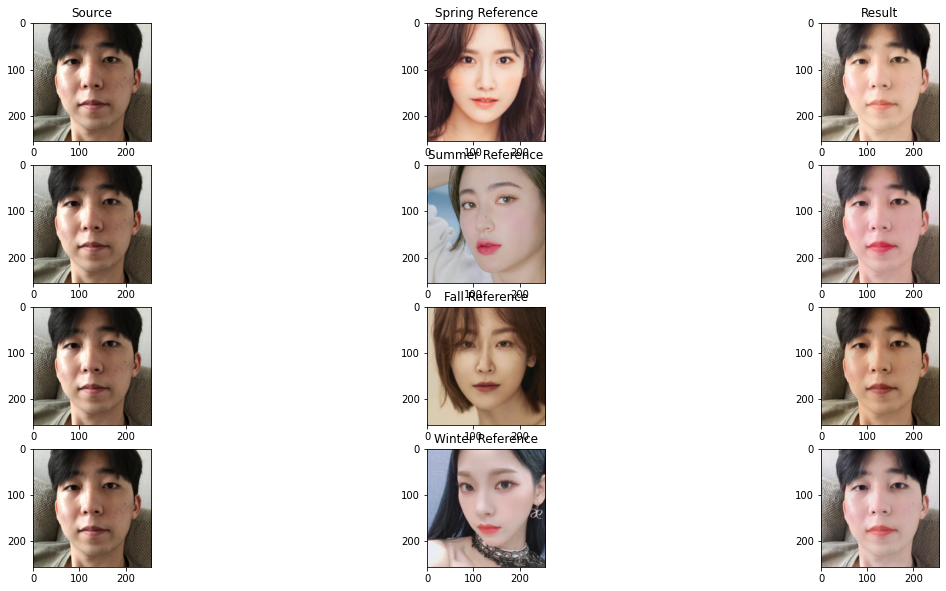

In [ ]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/나.jpg') # 소스 이미지 (no-makeup)
img1_faces = align_faces(img1)

src_img = img1_faces[0]
ref1_img = img2_faces[0]
ref2_img = img3_faces[0]
ref3_img = img4_faces[0]
ref4_img = img5_faces[0]

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0) # 배열에 차원을 추가

Y1_img = preprocess(ref1_img)
Y1_img = np.expand_dims(Y1_img, axis=0)

Y2_img = preprocess(ref2_img)
Y2_img = np.expand_dims(Y2_img, axis=0)

Y3_img = preprocess(ref3_img)
Y3_img = np.expand_dims(Y3_img, axis=0)

Y4_img = preprocess(ref4_img)
Y4_img = np.expand_dims(Y4_img, axis=0)


output1 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y1_img
})


output2 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y2_img
})


output3 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y3_img
})


output4 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y4_img
})


output1_img = postprocess(output1[0]) # output이 나오면 후처리를 실시.
output2_img = postprocess(output2[0])
output3_img = postprocess(output3[0])
output4_img = postprocess(output4[0])

fig, axes = plt.subplots(4, 3, figsize=(20, 10))
axes[0,0].set_title('Source')
axes[0,0].imshow(src_img)
axes[0,1].set_title('Spring Reference')
axes[0,1].imshow(ref1_img)
axes[0,2].set_title('Result')
axes[0,2].imshow(output1_img)

axes[1,0].imshow(src_img)
axes[1,1].set_title('Summer Reference')
axes[1,1].imshow(ref2_img)
axes[1,2].imshow(output2_img)

axes[2,0].imshow(src_img)
axes[2,1].set_title('Fall Reference')
axes[2,1].imshow(ref3_img)
axes[2,2].imshow(output3_img)

axes[3,0].imshow(src_img)
axes[3,1].set_title('Winter Reference')
axes[3,1].imshow(ref4_img)
axes[3,2].imshow(output4_img)


In [ ]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/정하.jpg') # 소스 이미지 (no-makeup)
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/봄웜톤.jpg')# 레퍼런스 이미지(reference image) 봄웜톤
img2_faces = align_faces(img2)

img3 = dlib.load_rgb_image('/content/drive/MyDrive/D&A_conference/BeautyGAN/카리나.jpg')  # 레퍼런스 이미지(reference image) 여름쿨톤
img3_faces = align_faces(img3)


src_img = img1_faces[0]
ref1_img = img2_faces[0]
ref2_img = img3_faces[0]


X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0) # 배열에 차원을 추가

Y1_img = preprocess(ref1_img)
Y1_img = np.expand_dims(Y1_img, axis=0)

Y2_img = preprocess(ref2_img)
Y2_img = np.expand_dims(Y2_img, axis=0)



output1 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y1_img
})


output2 = sess.run(Xs, feed_dict={ # XS는 output
    X: X_img,
    Y: Y2_img
})


output1_img = postprocess(output1[0]) # output이 나오면 후처리를 실시.
output2_img = postprocess(output2[0])


fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0,0].set_title('Source')
axes[0,0].imshow(src_img)

axes[0,1].set_title('First Reference')
axes[0,1].imshow(ref1_img)
axes[0,2].set_title('Result')
axes[0,2].imshow(output1_img)

axes[1,0].set_title('Source')
axes[1,0].imshow(src_img)
axes[1,1].set_title('Second Reference')
axes[1,1].imshow(ref2_img)
axes[1,2].imshow(output2_img)
axes[1,2].set_title('Result')

plt.tight_layout()
plt.show()
